# Generative Adversarial Networks (GANs)
So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
import tensorflow as tf
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.shape) for p in model.weights])
    return param_count

answers = np.load('gan-checks-tf.npz')

NOISE_DIM = 96

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 
 

**Heads-up**: Our MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

In [2]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

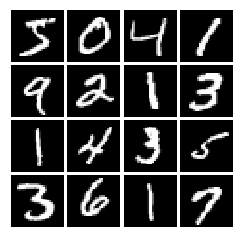

In [3]:
# show a batch
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [4]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    x = tf.nn.leaky_relu(x,alpha)
    return x
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Test your leaky ReLU implementation. You should get errors < 1e-10

In [5]:
def test_leaky_relu(x, y_true):
    y = leaky_relu(tf.constant(x))
    print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 1.11759e-08


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [6]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    noise = tf.random.uniform([batch_size,dim],minval = -1,maxval = 1)
    return noise
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Make sure noise is the correct shape and type:

In [7]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    z = sample_noise(batch_size, dim)
    # Check z has the correct shape
    assert z.get_shape().as_list() == [batch_size, dim]
    # Make sure z is a Tensor and not a numpy array
    assert isinstance(z, tf.Tensor)
    # Check that we get different noise for different evaluations
    z1 = sample_noise(batch_size, dim)
    z2 = sample_noise(batch_size, dim)
    assert not np.array_equal(z1, z2)
    # Check that we get the correct range
    assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
    print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. **Hint:** You should use the layers in `tf.keras.layers` to build the model.
All fully connected layers should include bias terms. For initialization, just use the default initializer used by the `tf.keras.layers` functions.

Architecture:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 1 
 
The output of the discriminator should thus have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [8]:
def discriminator():
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        tf.keras.layers.InputLayer(784),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.Dense(1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])
    return model

Test to make sure the number of parameters in the discriminator is correct:

In [9]:
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.keras.layers` to construct the model. All fully connected layers should include bias terms. Note that you can use the tf.nn module to access activation functions. Once again, use the default initializers for parameters.

Architecture:
 * Fully connected layer with inupt size tf.shape(z)[1] (the number of noise dimensions) and output size 1024
 * `ReLU`
 * Fully connected layer with output size 1024 
 * `ReLU`
 * Fully connected layer with output size 784
 * `TanH` (To restrict every element of the output to be in the range [-1,1])

In [10]:
def generator(noise_dim=NOISE_DIM):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        tf.keras.layers.InputLayer(noise_dim),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(784,activation = tf.nn.tanh)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])
    return model

Test to make sure the number of parameters in the generator is correct:

In [11]:
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/ones) and [tf.zeros](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/zeros) to generate labels for your discriminator. Use [tf.keras.losses.BinaryCrossentropy](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses/BinaryCrossentropy) to help compute your loss function.

In [12]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: Tensor of shape (N, 1) giving scores for the real data.
    - logits_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Returns:
    - loss: Tensor containing (scalar) the loss for the discriminator.
    """
    loss = None
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    real_loss = cross_entropy(tf.ones_like(logits_real), logits_real)
    fake_loss = cross_entropy(tf.zeros_like(logits_fake), logits_fake)
    loss = real_loss + fake_loss
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    loss = cross_entropy(tf.ones_like(logits_fake), logits_fake)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-8.

In [13]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(tf.constant(logits_real),
                                tf.constant(logits_fake))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 3.97058e-09


In [14]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(tf.constant(logits_fake))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 4.4518e-09


# Optimizing our loss
Make an `Adam` optimizer with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [15]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    - G_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    D_solver = tf.optimizers.Adam(learning_rate,beta1)
    G_solver = tf.optimizers.Adam(learning_rate,beta1)
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return D_solver, G_solver

# Training a GAN!
Well that wasn't so hard, was it? After the first epoch, you should see fuzzy outlines, clear shapes as you approach epoch 3, and decent shapes, about half of which will be sharp and clearly recognizable as we pass epoch 5. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [16]:
# a giant helper function
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss,\
              show_every=20, print_every=20, batch_size=128, num_epochs=10, noise_size=96):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - D: Discriminator model
    - G: Generator model
    - D_solver: an Optimizer for Discriminator
    - G_solver: an Optimizer for Generator
    - generator_loss: Generator loss
    - discriminator_loss: Discriminator loss
    Returns:
        Nothing
    """
    mnist = MNIST(batch_size=batch_size, shuffle=True)
    
    iter_count = 0
    for epoch in range(num_epochs):
        for (x, _) in mnist:
            with tf.GradientTape() as tape:
                real_data = x
                logits_real = D(preprocess_img(real_data))

                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)
                logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))

                d_total_error = discriminator_loss(logits_real, logits_fake)
                d_gradients = tape.gradient(d_total_error, D.trainable_variables)      
                D_solver.apply_gradients(zip(d_gradients, D.trainable_variables))
            
            with tf.GradientTape() as tape:
                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)

                gen_logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))
                g_error = generator_loss(gen_logits_fake)
                g_gradients = tape.gradient(g_error, G.trainable_variables)      
                G_solver.apply_gradients(zip(g_gradients, G.trainable_variables))

            if (iter_count % show_every == 0):
                print('Epoch: {}, Iter: {}, D: {:.4}, G:{:.4}'.format(epoch, iter_count,d_total_error,g_error))
                imgs_numpy = fake_images.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
            iter_count += 1
    
    # random noise fed into our generator
    z = sample_noise(batch_size, noise_size)
    # generated images
    G_sample = G(z)
    print('Final images')
    show_images(G_sample[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or about 2 minutes on GPU.

Epoch: 0, Iter: 0, D: 1.912, G:0.7383
Instructions for updating:
Use tf.identity instead.


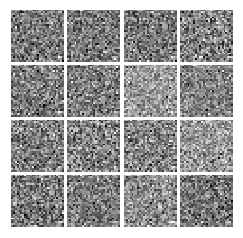

Epoch: 0, Iter: 20, D: 0.5992, G:0.9319


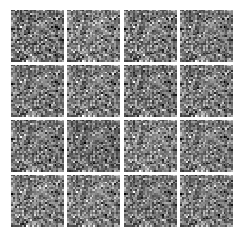

In [ ]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [76]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: Tensor of shape (N, 1) giving scores for the real data.
    - scores_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Outputs:
    - loss: A Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    loss = 0.5*tf.reduce_mean(tf.square(scores_real - 1)) + 0.5*tf.reduce_mean(tf.square(scores_fake))
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Outputs:
    - loss: A Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    loss = 0.5*tf.reduce_mean((tf.square(scores_fake-1)))
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

Test your LSGAN loss. You should see errors less than 1e-8.

In [77]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    
    d_loss = ls_discriminator_loss(tf.constant(score_real), tf.constant(score_fake))
    g_loss = ls_generator_loss(tf.constant(score_fake))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

Epoch: 0, Iter: 0, D: 2.184, G:0.521


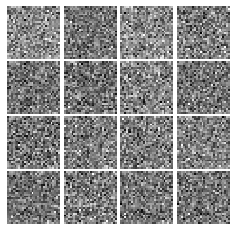

Epoch: 0, Iter: 20, D: 0.05783, G:0.631


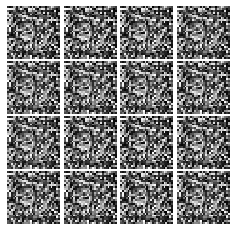

Epoch: 0, Iter: 40, D: 0.0237, G:0.8965


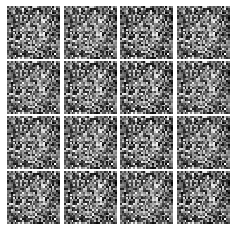

Epoch: 0, Iter: 60, D: 0.08117, G:0.8121


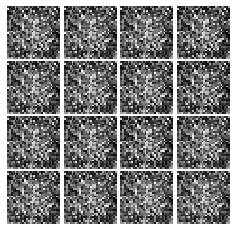

Epoch: 0, Iter: 80, D: 0.0537, G:0.4373


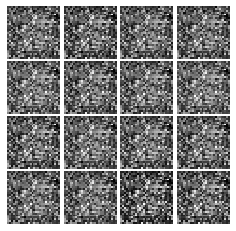

Epoch: 0, Iter: 100, D: 0.04699, G:0.7811


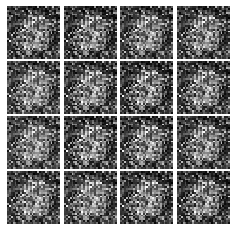

Epoch: 0, Iter: 120, D: 0.118, G:0.8606


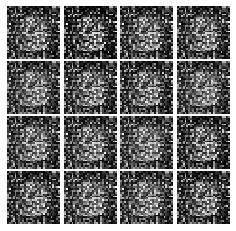

Epoch: 0, Iter: 140, D: 0.07433, G:0.4052


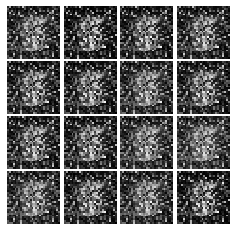

Epoch: 0, Iter: 160, D: 0.1399, G:0.1952


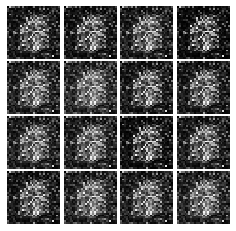

Epoch: 0, Iter: 180, D: 0.1418, G:0.3424


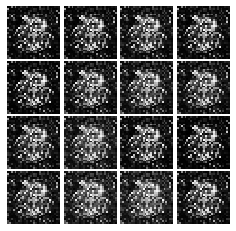

Epoch: 0, Iter: 200, D: 0.1512, G:0.2417


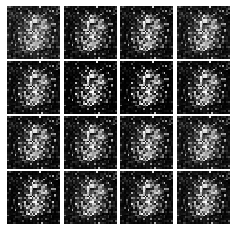

Epoch: 0, Iter: 220, D: 0.1444, G:0.4667


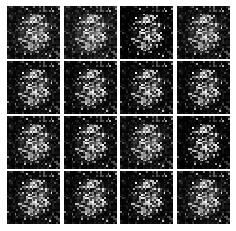

Epoch: 0, Iter: 240, D: 0.1885, G:0.6323


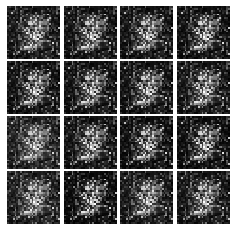

Epoch: 0, Iter: 260, D: 0.1024, G:0.4395


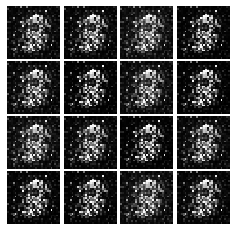

Epoch: 0, Iter: 280, D: 0.08855, G:0.3573


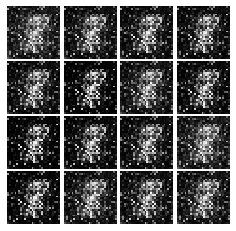

Epoch: 0, Iter: 300, D: 0.1569, G:0.8151


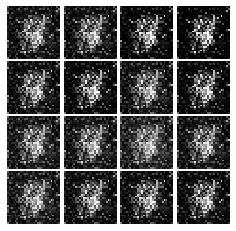

Epoch: 0, Iter: 320, D: 0.06861, G:0.5932


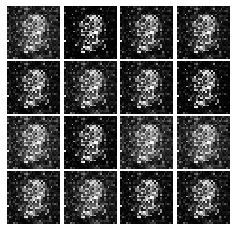

Epoch: 0, Iter: 340, D: 0.3691, G:0.01927


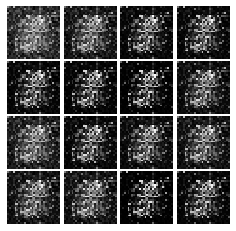

Epoch: 0, Iter: 360, D: 0.06593, G:0.4508


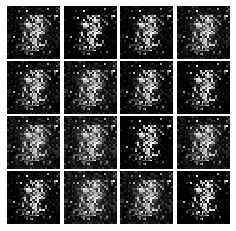

Epoch: 0, Iter: 380, D: 0.05413, G:0.462


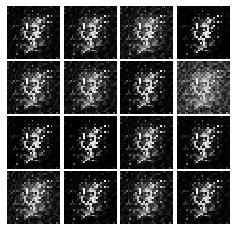

Epoch: 0, Iter: 400, D: 0.1723, G:0.478


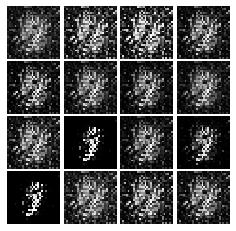

Epoch: 0, Iter: 420, D: 0.1238, G:0.3729


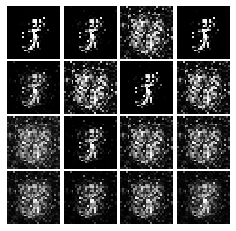

Epoch: 0, Iter: 440, D: 0.2348, G:0.953


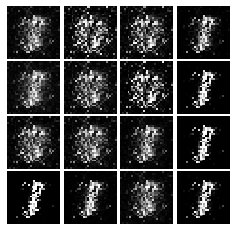

Epoch: 0, Iter: 460, D: 0.1842, G:1.056


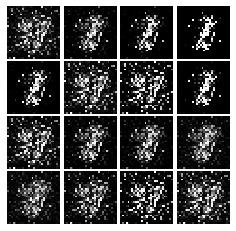

Epoch: 1, Iter: 480, D: 0.1408, G:0.6188


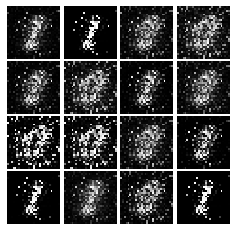

Epoch: 1, Iter: 500, D: 0.1719, G:0.5659


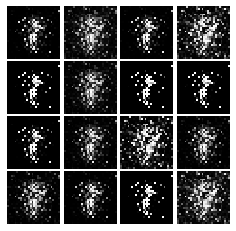

Epoch: 1, Iter: 520, D: 0.1241, G:0.6707


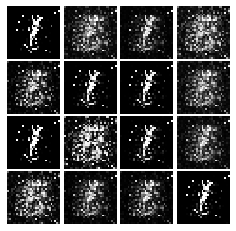

Epoch: 1, Iter: 540, D: 0.09409, G:0.4387


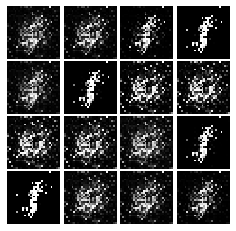

Epoch: 1, Iter: 560, D: 0.1031, G:0.4007


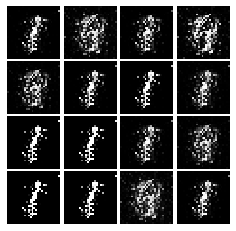

Epoch: 1, Iter: 580, D: 0.05911, G:0.4737


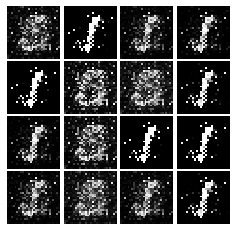

Epoch: 1, Iter: 600, D: 0.1191, G:0.5005


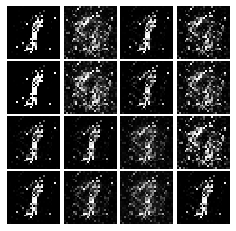

Epoch: 1, Iter: 620, D: 0.09105, G:0.4096


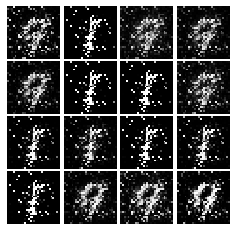

Epoch: 1, Iter: 640, D: 0.7455, G:0.1019


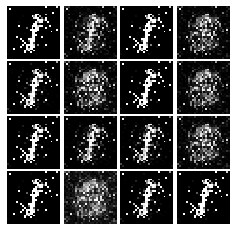

Epoch: 1, Iter: 660, D: 0.1167, G:0.3849


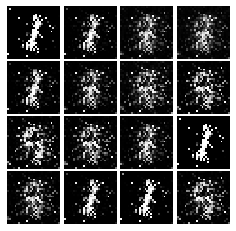

Epoch: 1, Iter: 680, D: 0.09298, G:0.3853


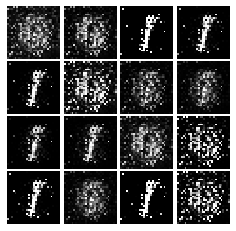

Epoch: 1, Iter: 700, D: 0.1847, G:0.4171


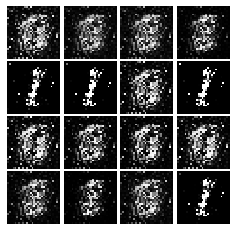

Epoch: 1, Iter: 720, D: 0.1191, G:0.4621


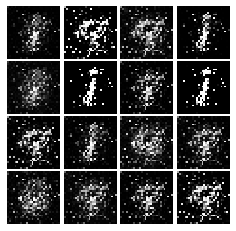

Epoch: 1, Iter: 740, D: 0.1015, G:0.3786


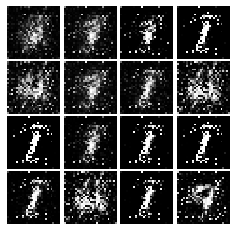

Epoch: 1, Iter: 760, D: 0.2288, G:0.3424


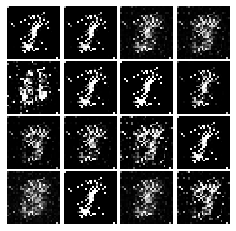

Epoch: 1, Iter: 780, D: 0.1315, G:0.2976


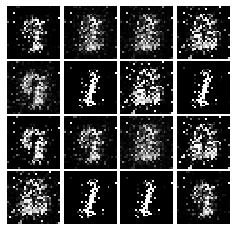

Epoch: 1, Iter: 800, D: 0.1188, G:0.3203


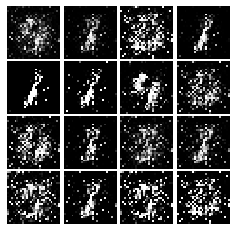

Epoch: 1, Iter: 820, D: 0.1406, G:0.3186


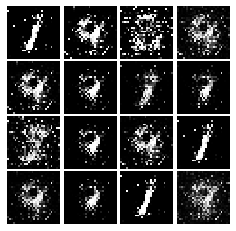

Epoch: 1, Iter: 840, D: 0.1412, G:0.1549


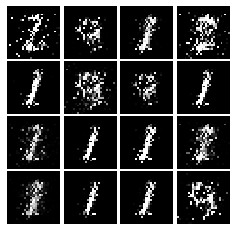

Epoch: 1, Iter: 860, D: 0.1343, G:0.3921


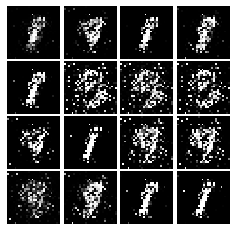

Epoch: 1, Iter: 880, D: 0.09914, G:0.3651


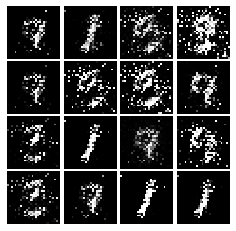

Epoch: 1, Iter: 900, D: 0.127, G:0.3477


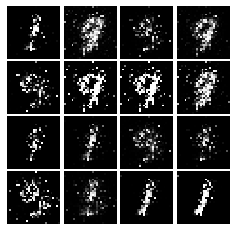

Epoch: 1, Iter: 920, D: 0.1073, G:0.3875


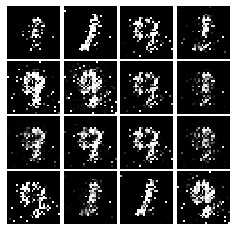

Epoch: 2, Iter: 940, D: 0.1719, G:0.2541


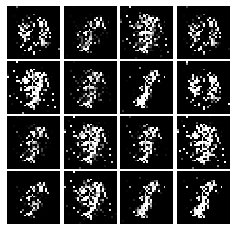

Epoch: 2, Iter: 960, D: 0.07279, G:0.4567


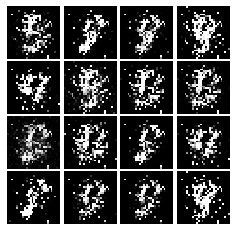

Epoch: 2, Iter: 980, D: 0.1772, G:0.3793


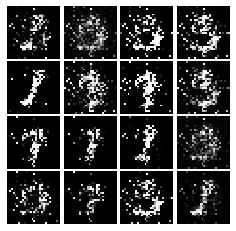

Epoch: 2, Iter: 1000, D: 0.0853, G:0.3854


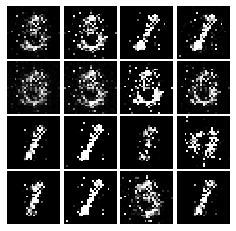

Epoch: 2, Iter: 1020, D: 0.09491, G:0.4257


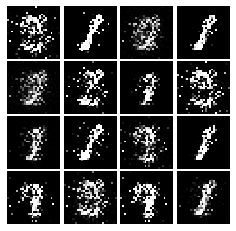

Epoch: 2, Iter: 1040, D: 0.0799, G:0.4935


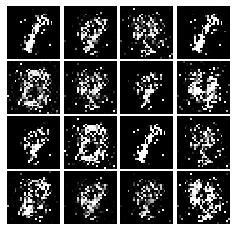

Epoch: 2, Iter: 1060, D: 0.1106, G:0.3078


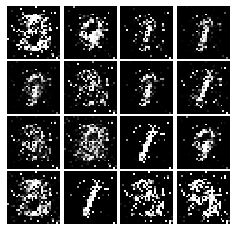

Epoch: 2, Iter: 1080, D: 0.09973, G:0.458


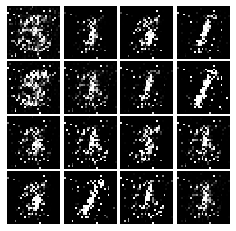

Epoch: 2, Iter: 1100, D: 0.138, G:0.4975


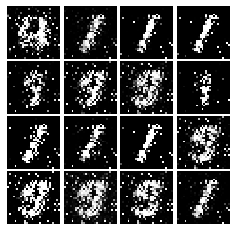

Epoch: 2, Iter: 1120, D: 0.0904, G:0.6548


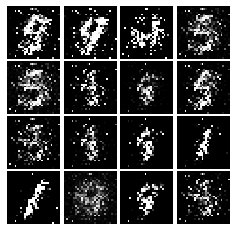

Epoch: 2, Iter: 1140, D: 0.1275, G:0.9883


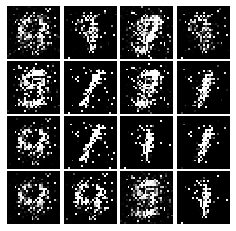

Epoch: 2, Iter: 1160, D: 0.1356, G:0.3364


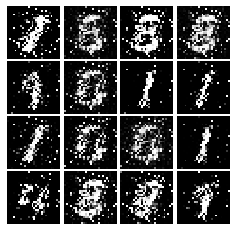

Epoch: 2, Iter: 1180, D: 0.1565, G:0.1084


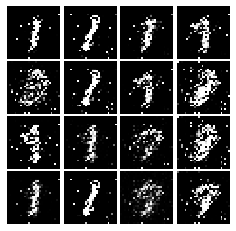

Epoch: 2, Iter: 1200, D: 0.1295, G:0.3928


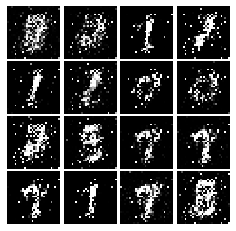

Epoch: 2, Iter: 1220, D: 0.1253, G:0.4046


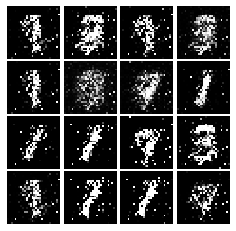

Epoch: 2, Iter: 1240, D: 0.1316, G:0.3571


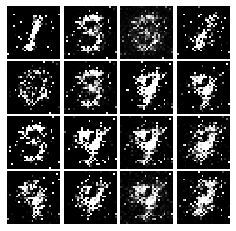

Epoch: 2, Iter: 1260, D: 0.3431, G:0.1612


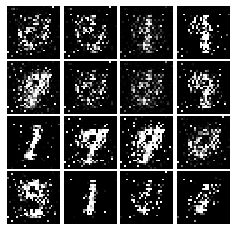

Epoch: 2, Iter: 1280, D: 0.4328, G:0.1805


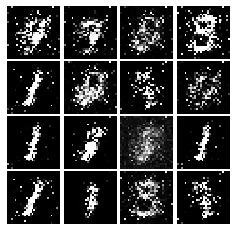

Epoch: 2, Iter: 1300, D: 0.1505, G:0.3633


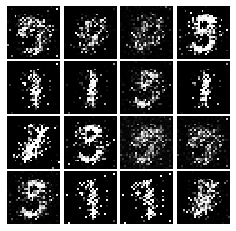

Epoch: 2, Iter: 1320, D: 0.188, G:0.2545


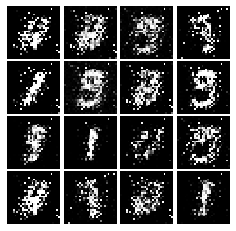

Epoch: 2, Iter: 1340, D: 0.1814, G:0.1782


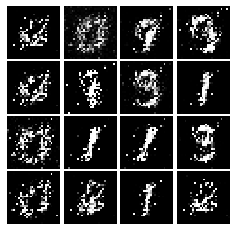

Epoch: 2, Iter: 1360, D: 0.1389, G:0.531


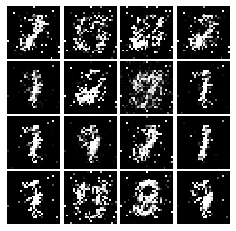

Epoch: 2, Iter: 1380, D: 0.1966, G:0.3042


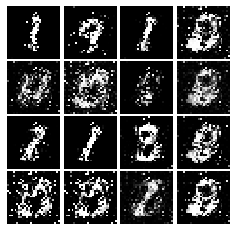

Epoch: 2, Iter: 1400, D: 0.1286, G:0.3293


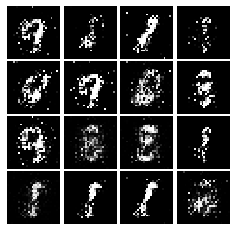

Epoch: 3, Iter: 1420, D: 0.1731, G:0.3274


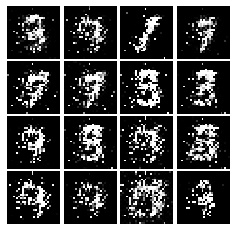

Epoch: 3, Iter: 1440, D: 0.186, G:0.5358


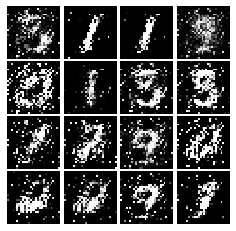

Epoch: 3, Iter: 1460, D: 0.2241, G:0.2461


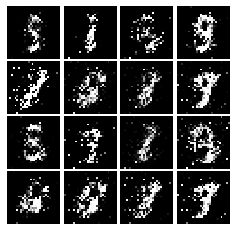

Epoch: 3, Iter: 1480, D: 0.1979, G:0.3246


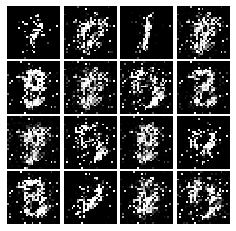

Epoch: 3, Iter: 1500, D: 0.1622, G:0.2787


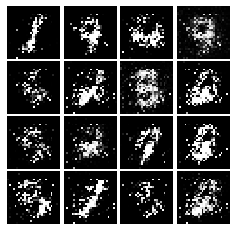

Epoch: 3, Iter: 1520, D: 0.1664, G:0.2167


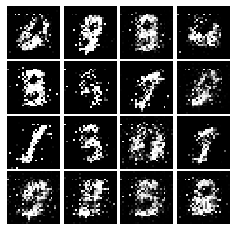

Epoch: 3, Iter: 1540, D: 0.1979, G:0.1983


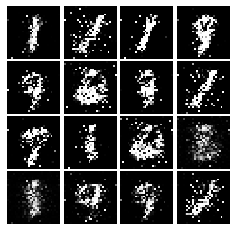

Epoch: 3, Iter: 1560, D: 0.1794, G:0.2831


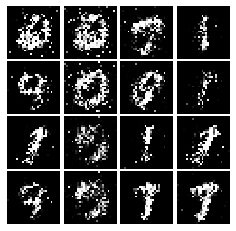

Epoch: 3, Iter: 1580, D: 0.2686, G:0.3188


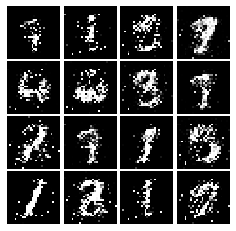

Epoch: 3, Iter: 1600, D: 0.205, G:0.1564


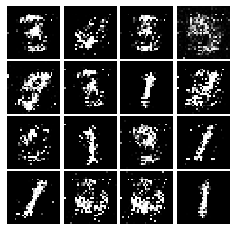

Epoch: 3, Iter: 1620, D: 0.2151, G:0.3132


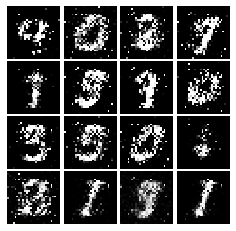

Epoch: 3, Iter: 1640, D: 0.1405, G:0.3605


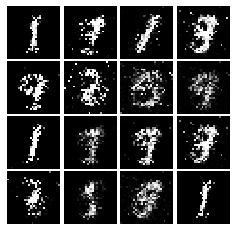

Epoch: 3, Iter: 1660, D: 0.1435, G:0.3301


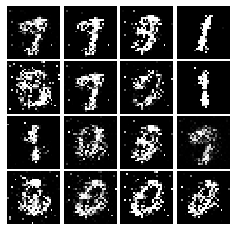

Epoch: 3, Iter: 1680, D: 0.1782, G:0.249


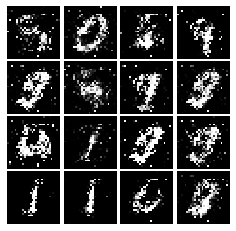

Epoch: 3, Iter: 1700, D: 0.1795, G:0.2436


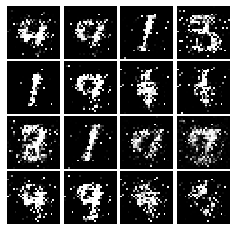

Epoch: 3, Iter: 1720, D: 0.3035, G:0.5513


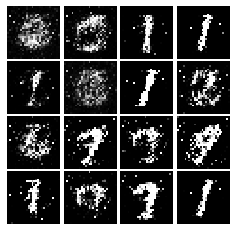

Epoch: 3, Iter: 1740, D: 0.1957, G:0.2069


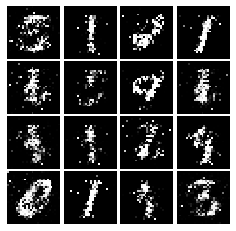

Epoch: 3, Iter: 1760, D: 0.2164, G:0.2075


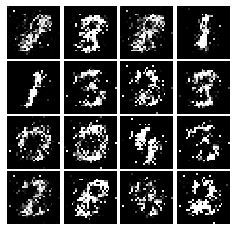

Epoch: 3, Iter: 1780, D: 0.1681, G:0.2827


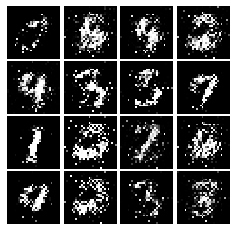

Epoch: 3, Iter: 1800, D: 0.2129, G:0.1842


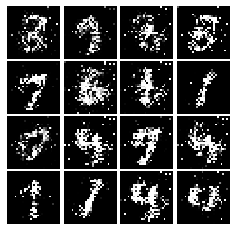

Epoch: 3, Iter: 1820, D: 0.195, G:0.1914


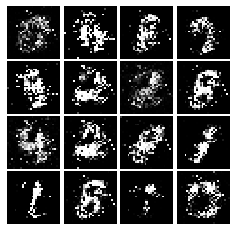

Epoch: 3, Iter: 1840, D: 0.6036, G:0.4104


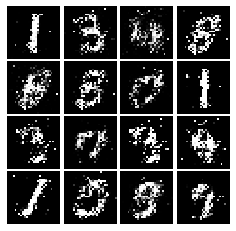

Epoch: 3, Iter: 1860, D: 0.186, G:0.2367


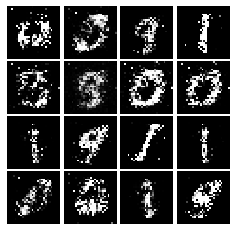

Epoch: 4, Iter: 1880, D: 0.177, G:0.2571


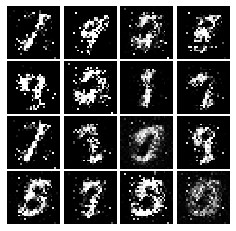

Epoch: 4, Iter: 1900, D: 0.1935, G:0.2189


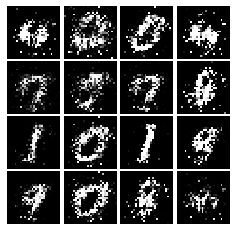

Epoch: 4, Iter: 1920, D: 0.1875, G:0.2513


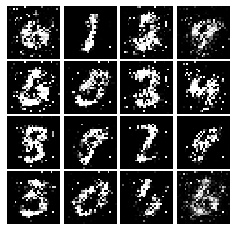

Epoch: 4, Iter: 1940, D: 0.2009, G:0.1563


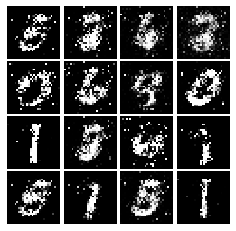

Epoch: 4, Iter: 1960, D: 0.1992, G:0.1941


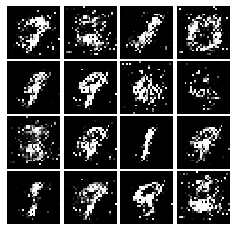

Epoch: 4, Iter: 1980, D: 0.2054, G:0.2022


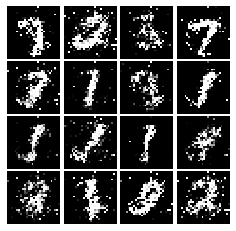

Epoch: 4, Iter: 2000, D: 0.1964, G:0.1909


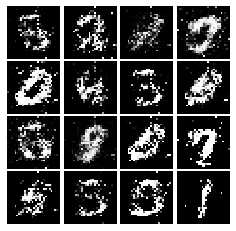

Epoch: 4, Iter: 2020, D: 0.1969, G:0.2119


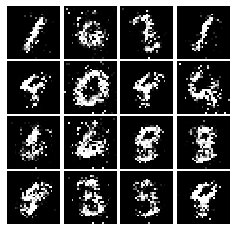

Epoch: 4, Iter: 2040, D: 0.2347, G:0.1878


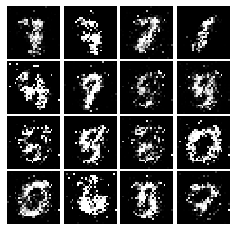

Epoch: 4, Iter: 2060, D: 0.2222, G:0.1975


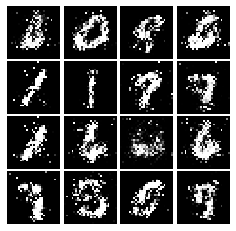

Epoch: 4, Iter: 2080, D: 0.2034, G:0.1877


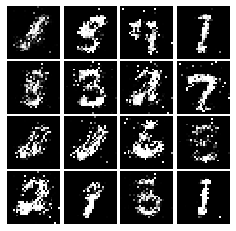

Epoch: 4, Iter: 2100, D: 0.2063, G:0.1976


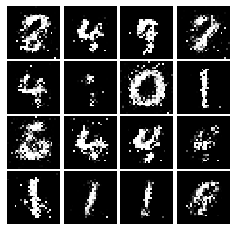

Epoch: 4, Iter: 2120, D: 0.2182, G:0.1713


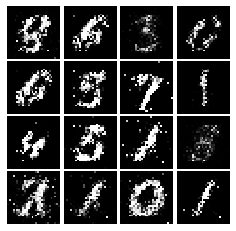

Epoch: 4, Iter: 2140, D: 0.2129, G:0.1894


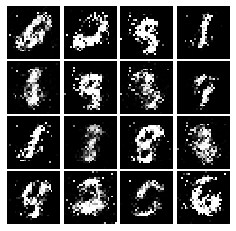

Epoch: 4, Iter: 2160, D: 0.2186, G:0.2094


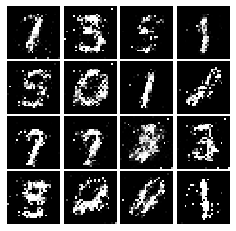

Epoch: 4, Iter: 2180, D: 0.1934, G:0.211


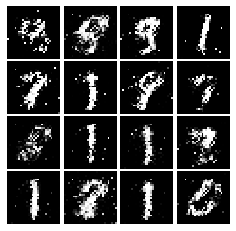

Epoch: 4, Iter: 2200, D: 0.1978, G:0.2122


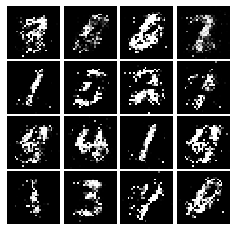

Epoch: 4, Iter: 2220, D: 0.2211, G:0.1924


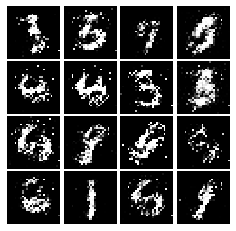

Epoch: 4, Iter: 2240, D: 0.2223, G:0.1546


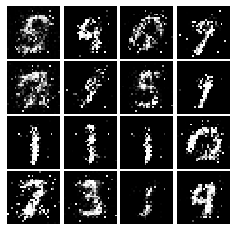

Epoch: 4, Iter: 2260, D: 0.2214, G:0.1932


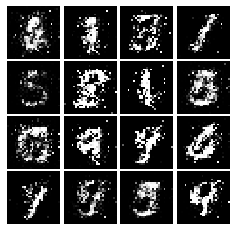

Epoch: 4, Iter: 2280, D: 0.1994, G:0.1848


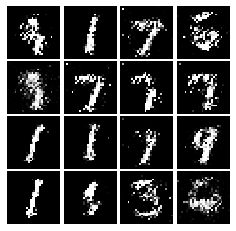

Epoch: 4, Iter: 2300, D: 0.2079, G:0.1916


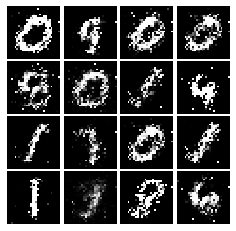

Epoch: 4, Iter: 2320, D: 0.2123, G:0.2055


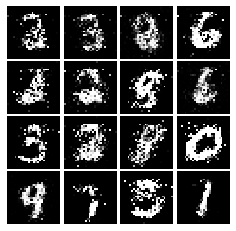

Epoch: 4, Iter: 2340, D: 0.2079, G:0.2041


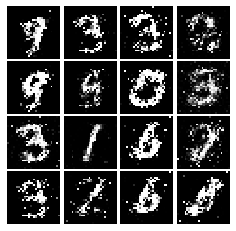

Epoch: 5, Iter: 2360, D: 0.2217, G:0.1663


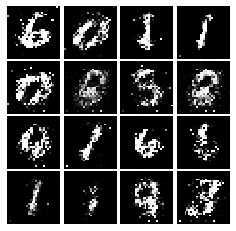

Epoch: 5, Iter: 2380, D: 0.208, G:0.1827


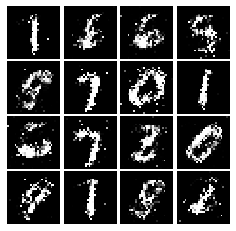

Epoch: 5, Iter: 2400, D: 0.218, G:0.1663


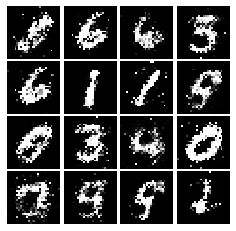

Epoch: 5, Iter: 2420, D: 0.2138, G:0.2041


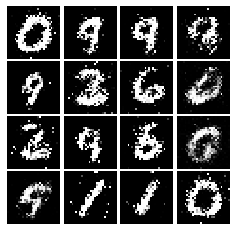

Epoch: 5, Iter: 2440, D: 0.2311, G:0.1668


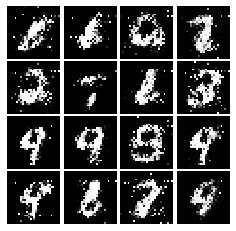

Epoch: 5, Iter: 2460, D: 0.1949, G:0.2005


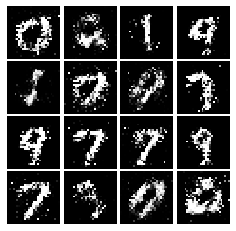

Epoch: 5, Iter: 2480, D: 0.2177, G:0.2604


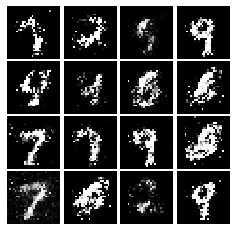

Epoch: 5, Iter: 2500, D: 0.1892, G:0.1912


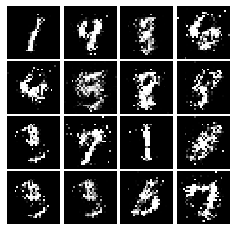

Epoch: 5, Iter: 2520, D: 0.2464, G:0.1788


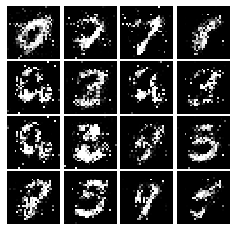

Epoch: 5, Iter: 2540, D: 0.2188, G:0.1627


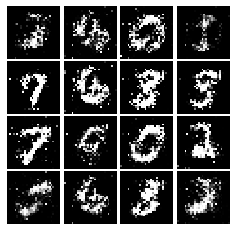

Epoch: 5, Iter: 2560, D: 0.2391, G:0.1543


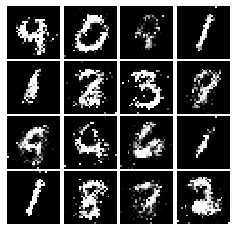

Epoch: 5, Iter: 2580, D: 0.2275, G:0.1643


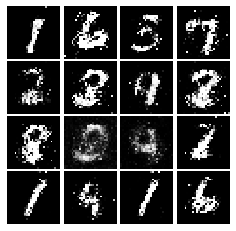

Epoch: 5, Iter: 2600, D: 0.2623, G:0.1443


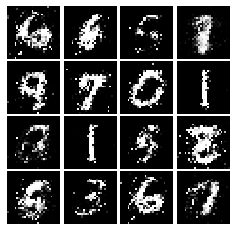

Epoch: 5, Iter: 2620, D: 0.2005, G:0.1745


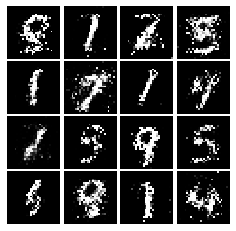

Epoch: 5, Iter: 2640, D: 0.1982, G:0.1973


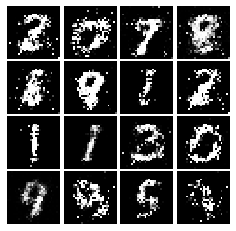

Epoch: 5, Iter: 2660, D: 0.2288, G:0.1672


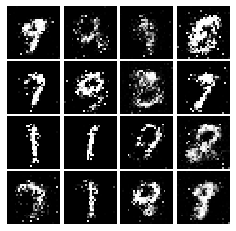

Epoch: 5, Iter: 2680, D: 0.2675, G:0.1615


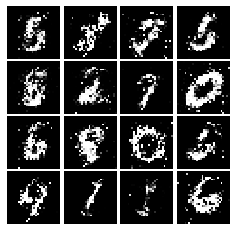

Epoch: 5, Iter: 2700, D: 0.262, G:0.232


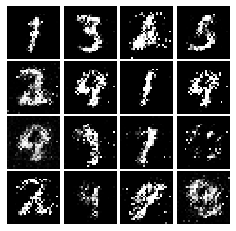

Epoch: 5, Iter: 2720, D: 0.2151, G:0.1854


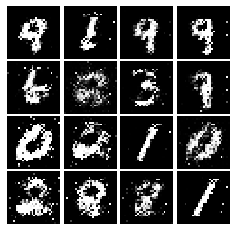

Epoch: 5, Iter: 2740, D: 0.2125, G:0.2052


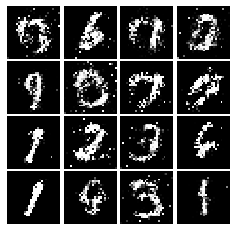

Epoch: 5, Iter: 2760, D: 0.2238, G:0.1747


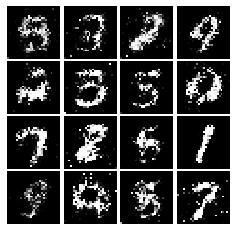

Epoch: 5, Iter: 2780, D: 0.2208, G:0.1693


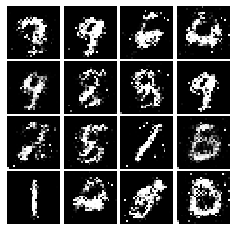

Epoch: 5, Iter: 2800, D: 0.2051, G:0.1797


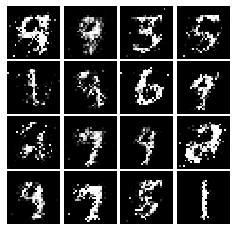

Epoch: 6, Iter: 2820, D: 0.21, G:0.1892


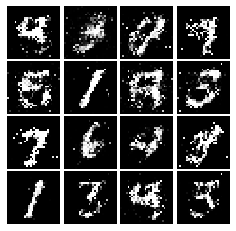

Epoch: 6, Iter: 2840, D: 0.2288, G:0.2221


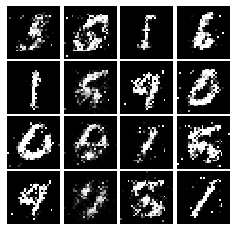

Epoch: 6, Iter: 2860, D: 0.2096, G:0.1943


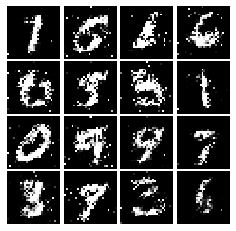

Epoch: 6, Iter: 2880, D: 0.1841, G:0.1917


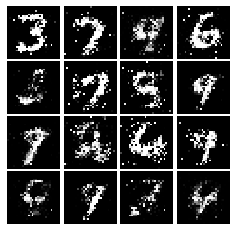

Epoch: 6, Iter: 2900, D: 0.2151, G:0.1895


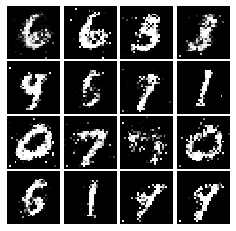

Epoch: 6, Iter: 2920, D: 0.2298, G:0.1601


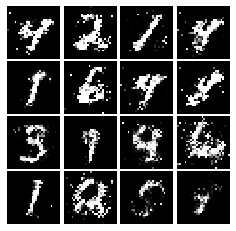

Epoch: 6, Iter: 2940, D: 0.2184, G:0.1855


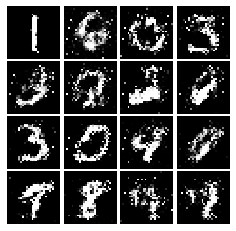

Epoch: 6, Iter: 2960, D: 0.2439, G:0.1602


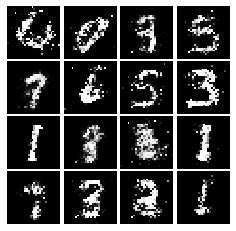

Epoch: 6, Iter: 2980, D: 0.2402, G:0.1491


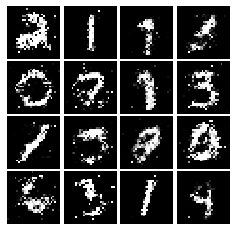

Epoch: 6, Iter: 3000, D: 0.2198, G:0.1837


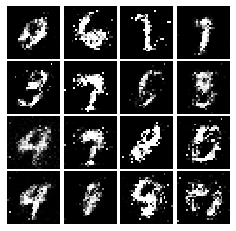

Epoch: 6, Iter: 3020, D: 0.2315, G:0.1554


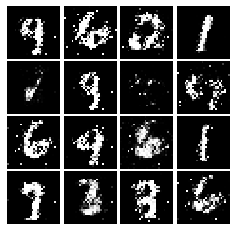

Epoch: 6, Iter: 3040, D: 0.2278, G:0.1926


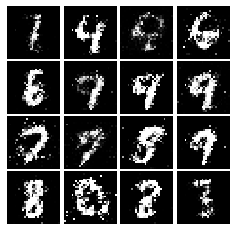

Epoch: 6, Iter: 3060, D: 0.2185, G:0.1641


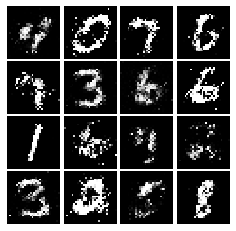

Epoch: 6, Iter: 3080, D: 0.2193, G:0.1879


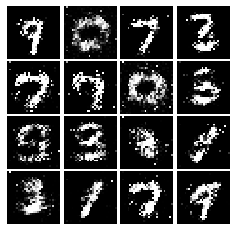

Epoch: 6, Iter: 3100, D: 0.1996, G:0.2093


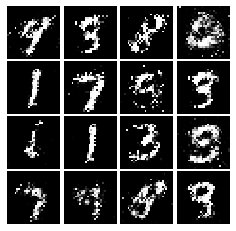

Epoch: 6, Iter: 3120, D: 0.2138, G:0.1788


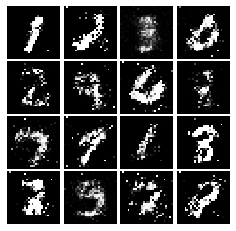

Epoch: 6, Iter: 3140, D: 0.2466, G:0.1545


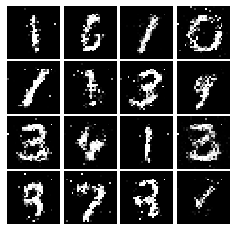

Epoch: 6, Iter: 3160, D: 0.2131, G:0.1562


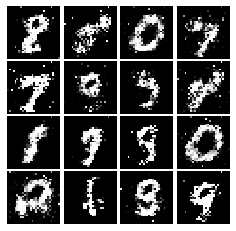

Epoch: 6, Iter: 3180, D: 0.2191, G:0.194


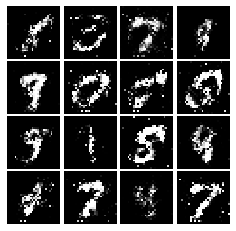

Epoch: 6, Iter: 3200, D: 0.2383, G:0.2169


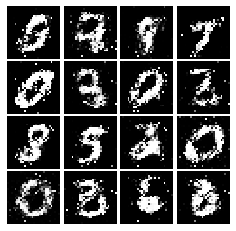

Epoch: 6, Iter: 3220, D: 0.2227, G:0.1836


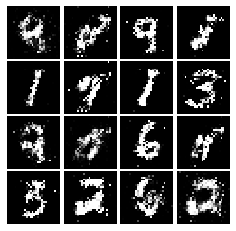

Epoch: 6, Iter: 3240, D: 0.2032, G:0.193


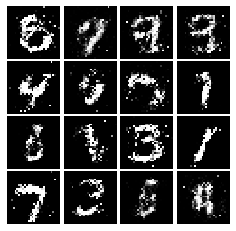

Epoch: 6, Iter: 3260, D: 0.2154, G:0.1756


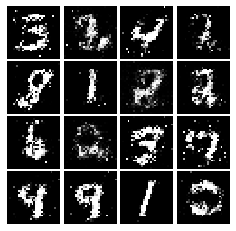

Epoch: 6, Iter: 3280, D: 0.2389, G:0.1772


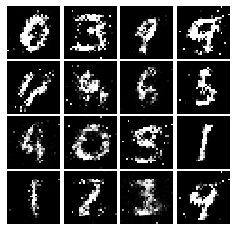

Epoch: 7, Iter: 3300, D: 0.2201, G:0.1858


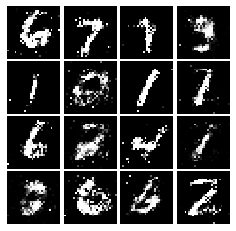

Epoch: 7, Iter: 3320, D: 0.2256, G:0.1786


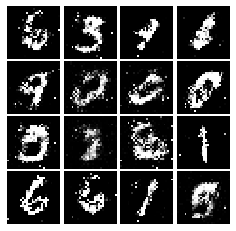

Epoch: 7, Iter: 3340, D: 0.1989, G:0.2029


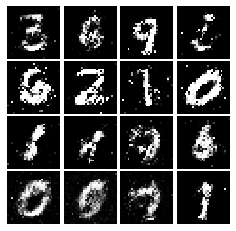

Epoch: 7, Iter: 3360, D: 0.215, G:0.1741


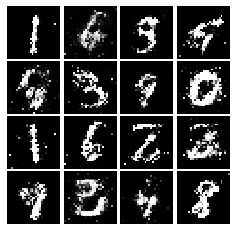

Epoch: 7, Iter: 3380, D: 0.2205, G:0.1541


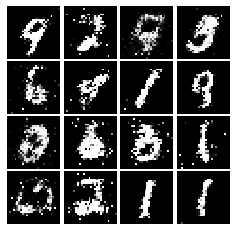

Epoch: 7, Iter: 3400, D: 0.2269, G:0.1749


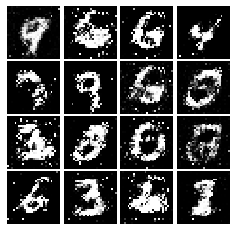

Epoch: 7, Iter: 3420, D: 0.2041, G:0.1654


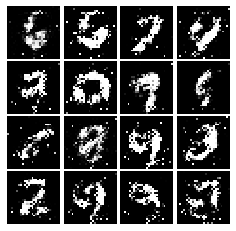

Epoch: 7, Iter: 3440, D: 0.235, G:0.1991


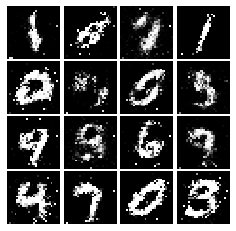

Epoch: 7, Iter: 3460, D: 0.2155, G:0.1523


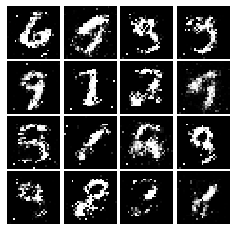

Epoch: 7, Iter: 3480, D: 0.2275, G:0.153


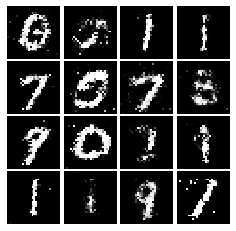

Epoch: 7, Iter: 3500, D: 0.2314, G:0.1781


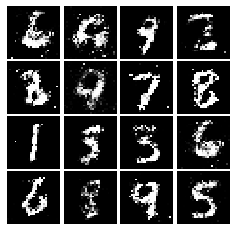

Epoch: 7, Iter: 3520, D: 0.2388, G:0.155


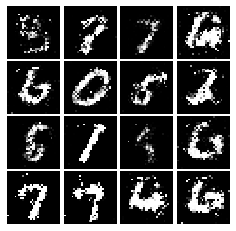

Epoch: 7, Iter: 3540, D: 0.2183, G:0.1825


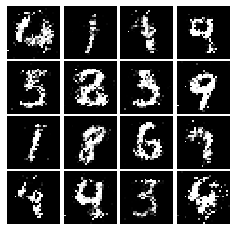

Epoch: 7, Iter: 3560, D: 0.2222, G:0.1913


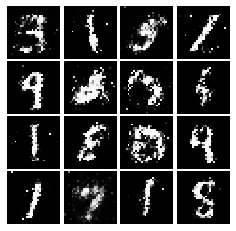

Epoch: 7, Iter: 3580, D: 0.2116, G:0.172


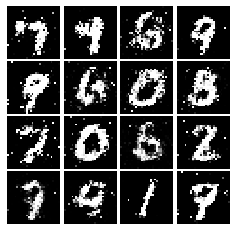

Epoch: 7, Iter: 3600, D: 0.2263, G:0.1552


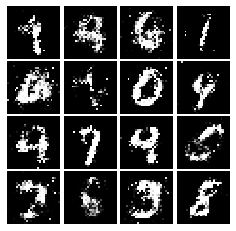

Epoch: 7, Iter: 3620, D: 0.2198, G:0.1757


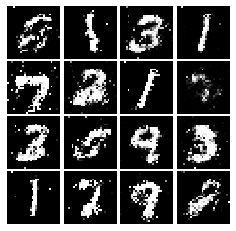

Epoch: 7, Iter: 3640, D: 0.2392, G:0.1665


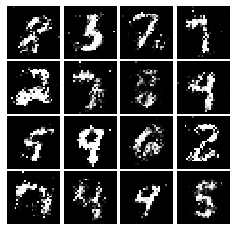

Epoch: 7, Iter: 3660, D: 0.2382, G:0.1498


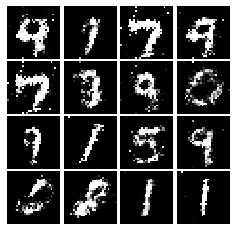

Epoch: 7, Iter: 3680, D: 0.2385, G:0.1732


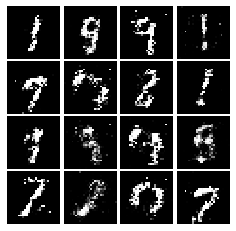

Epoch: 7, Iter: 3700, D: 0.2137, G:0.1852


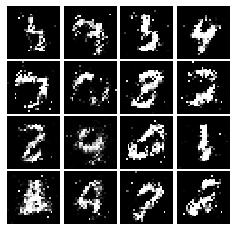

Epoch: 7, Iter: 3720, D: 0.2306, G:0.1935


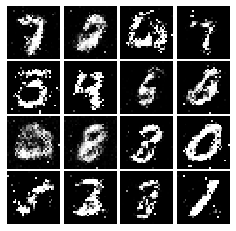

Epoch: 7, Iter: 3740, D: 0.2341, G:0.1864


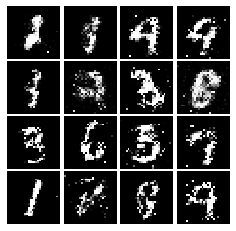

Epoch: 8, Iter: 3760, D: 0.2258, G:0.1895


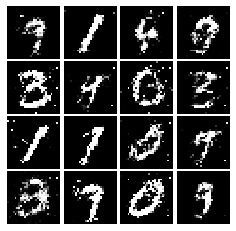

Epoch: 8, Iter: 3780, D: 0.2472, G:0.1563


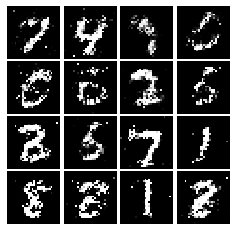

Epoch: 8, Iter: 3800, D: 0.2329, G:0.1591


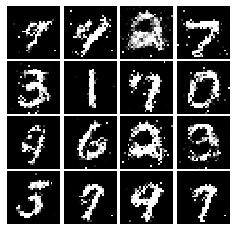

Epoch: 8, Iter: 3820, D: 0.2205, G:0.1572


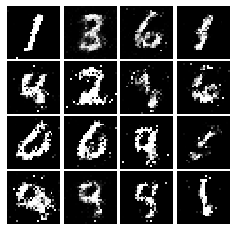

Epoch: 8, Iter: 3840, D: 0.2253, G:0.195


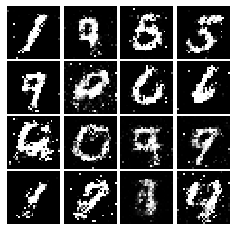

Epoch: 8, Iter: 3860, D: 0.2145, G:0.1475


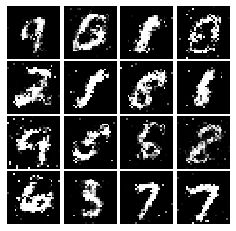

Epoch: 8, Iter: 3880, D: 0.232, G:0.1428


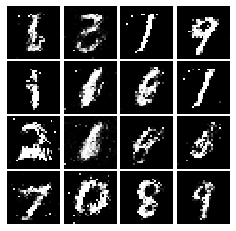

Epoch: 8, Iter: 3900, D: 0.2422, G:0.1461


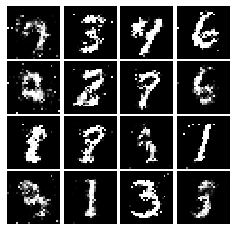

Epoch: 8, Iter: 3920, D: 0.218, G:0.1615


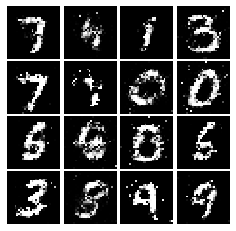

Epoch: 8, Iter: 3940, D: 0.2297, G:0.1917


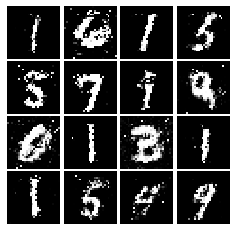

Epoch: 8, Iter: 3960, D: 0.2188, G:0.175


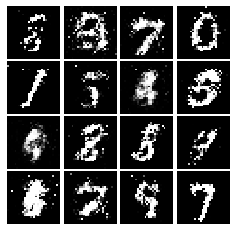

Epoch: 8, Iter: 3980, D: 0.2228, G:0.1867


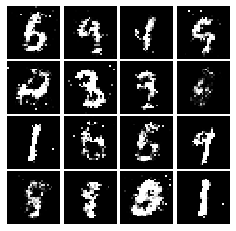

Epoch: 8, Iter: 4000, D: 0.2185, G:0.1738


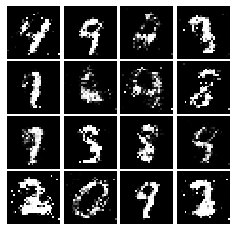

Epoch: 8, Iter: 4020, D: 0.2312, G:0.1273


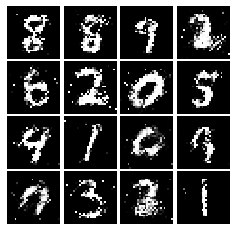

Epoch: 8, Iter: 4040, D: 0.2454, G:0.1859


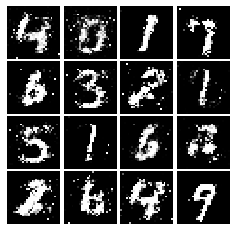

Epoch: 8, Iter: 4060, D: 0.2336, G:0.1707


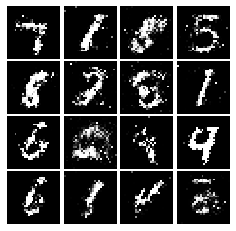

Epoch: 8, Iter: 4080, D: 0.2381, G:0.1625


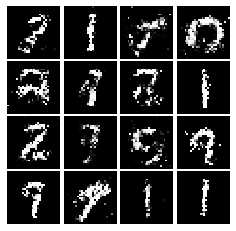

Epoch: 8, Iter: 4100, D: 0.2252, G:0.1636


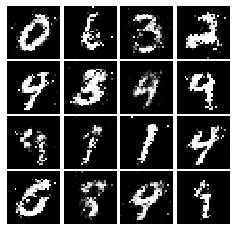

Epoch: 8, Iter: 4120, D: 0.223, G:0.1902


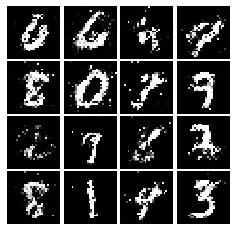

Epoch: 8, Iter: 4140, D: 0.2197, G:0.1824


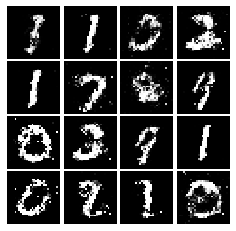

Epoch: 8, Iter: 4160, D: 0.2327, G:0.1786


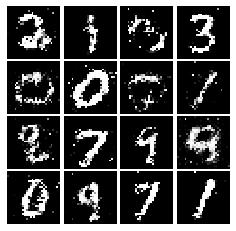

Epoch: 8, Iter: 4180, D: 0.2424, G:0.1526


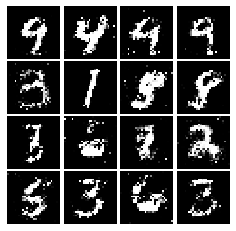

Epoch: 8, Iter: 4200, D: 0.2193, G:0.1975


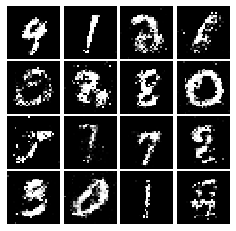

Epoch: 8, Iter: 4220, D: 0.2283, G:0.1911


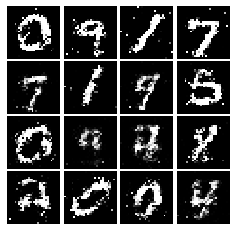

Epoch: 9, Iter: 4240, D: 0.2339, G:0.1532


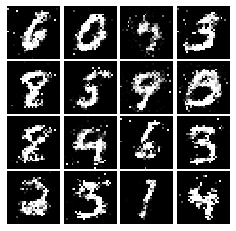

Epoch: 9, Iter: 4260, D: 0.2501, G:0.1711


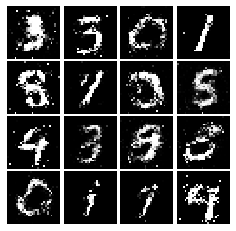

Epoch: 9, Iter: 4280, D: 0.2657, G:0.1618


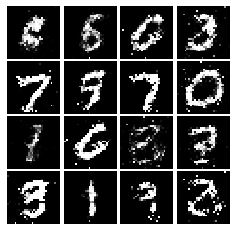

Epoch: 9, Iter: 4300, D: 0.2447, G:0.2094


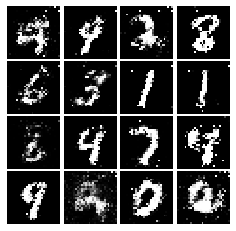

Epoch: 9, Iter: 4320, D: 0.2059, G:0.1603


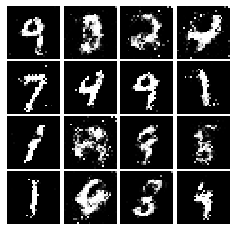

Epoch: 9, Iter: 4340, D: 0.2366, G:0.1556


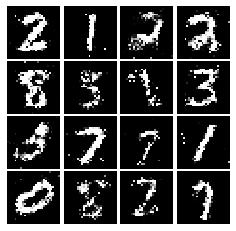

Epoch: 9, Iter: 4360, D: 0.2315, G:0.148


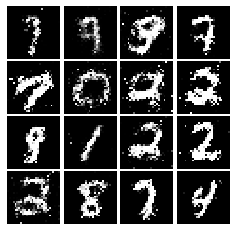

Epoch: 9, Iter: 4380, D: 0.239, G:0.1489


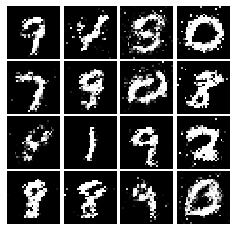

Epoch: 9, Iter: 4400, D: 0.2238, G:0.1687


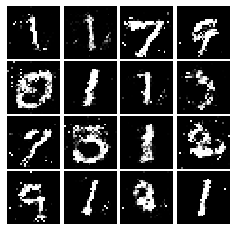

Epoch: 9, Iter: 4420, D: 0.2214, G:0.1769


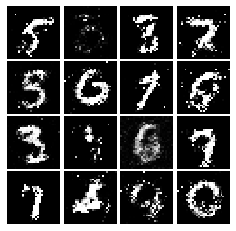

Epoch: 9, Iter: 4440, D: 0.2655, G:0.1626


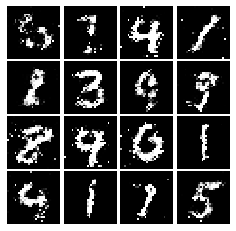

Epoch: 9, Iter: 4460, D: 0.2244, G:0.1518


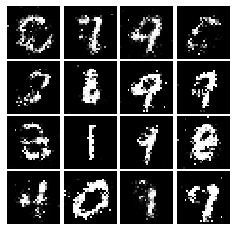

Epoch: 9, Iter: 4480, D: 0.213, G:0.1679


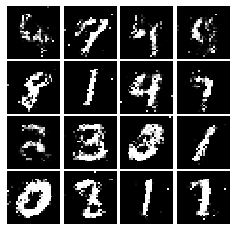

Epoch: 9, Iter: 4500, D: 0.2676, G:0.1522


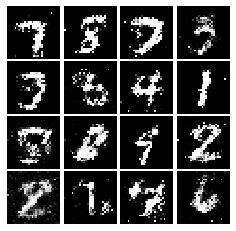

Epoch: 9, Iter: 4520, D: 0.241, G:0.1535


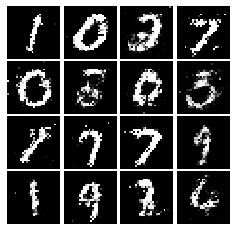

Epoch: 9, Iter: 4540, D: 0.2549, G:0.1532


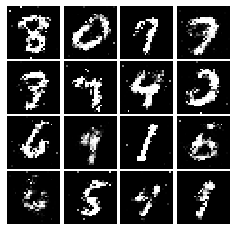

Epoch: 9, Iter: 4560, D: 0.2359, G:0.1509


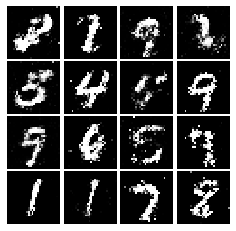

Epoch: 9, Iter: 4580, D: 0.2389, G:0.1585


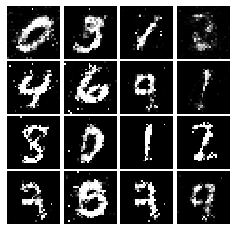

Epoch: 9, Iter: 4600, D: 0.2337, G:0.1659


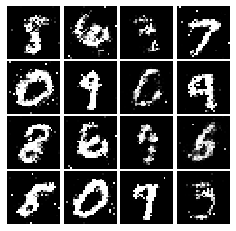

Epoch: 9, Iter: 4620, D: 0.2506, G:0.1545


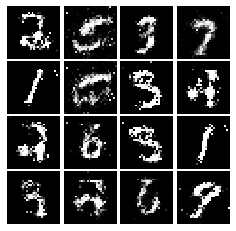

Epoch: 9, Iter: 4640, D: 0.2313, G:0.1392


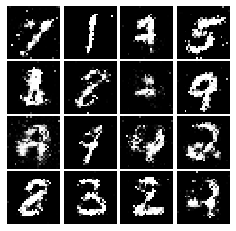

Epoch: 9, Iter: 4660, D: 0.2292, G:0.1724


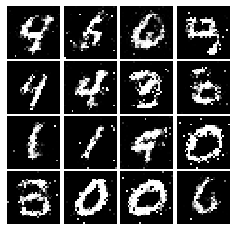

Epoch: 9, Iter: 4680, D: 0.2364, G:0.1663


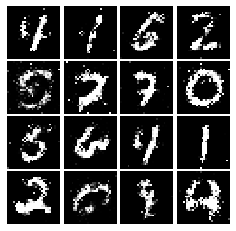

Final images


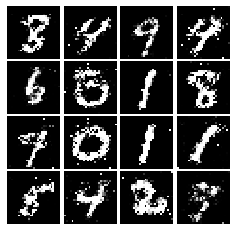

In [78]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
run_a_gan(D, G, D_solver, G_solver, ls_discriminator_loss, ls_generator_loss)

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. Please use `tf.keras.layers` to define the following architecture:

Architecture:
* Conv2D: 32 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Once again, please use biases for all convolutional and fully connected layers, and use the default parameter initializers. Note that a padding of 0 can be accomplished with the 'VALID' padding option.

In [89]:
def discriminator():
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        tf.keras.layers.InputLayer(784),
        tf.keras.layers.Reshape((28,28,1)),
        tf.keras.layers.Conv2D(32,(5,5),strides = 1,padding = 'VALID'),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.MaxPool2D((2,2),strides = 2),
        tf.keras.layers.Conv2D(64,(5,5),strides = 1,padding = 'VALID'),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.MaxPool2D((2,2),strides = 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4*4*64),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.Dense(1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])
    return model

model = discriminator()
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. Please use `tf.keras.layers` for your implementation. You might find the documentation for [tf.keras.layers.Conv2DTranspose](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2DTranspose) useful. The architecture is as follows.

Architecture:
* Fully connected with output size 1024 
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Resize into Image Tensor of size 7, 7, 128
* Conv2D^T (transpose): 64 filters of 4x4, stride 2
* `ReLU`
* BatchNorm
* Conv2d^T (transpose): 1 filter of 4x4, stride 2
* `TanH`

Once again, use biases for the fully connected and transpose convolutional layers. Please use the default initializers for your parameters. For padding, choose the 'same' option for transpose convolutions. For Batch Normalization, assume we are always in 'training' mode.

In [106]:
def generator(noise_dim=NOISE_DIM):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    model = tf.keras.models.Sequential([
    # TODO: implement architecture
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    tf.keras.layers.InputLayer(noise_dim),
    tf.keras.layers.Dense(1024,activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7*7*128,activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Reshape((7,7,128)),
    tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(4,4),strides = 2,activation = tf.nn.relu,padding = 'SAME'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(4,4),strides = 2,activation = tf.tanh,padding = 'SAME')
    ])
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return model
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

Epoch: 0, Iter: 0, D: 1.303, G:0.6657


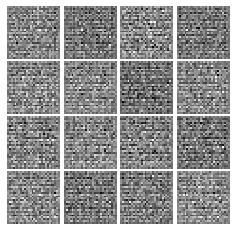

Epoch: 0, Iter: 20, D: 0.4896, G:1.332


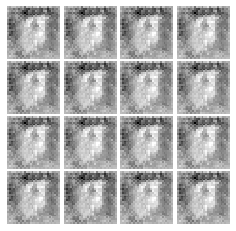

Epoch: 0, Iter: 40, D: 0.2692, G:1.958


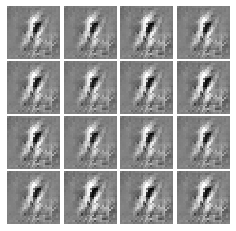

Epoch: 0, Iter: 60, D: 0.5259, G:6.831


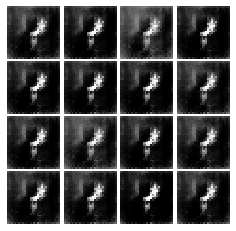

Epoch: 0, Iter: 80, D: 1.291, G:1.698


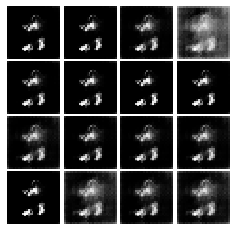

Epoch: 0, Iter: 100, D: 0.05434, G:5.147


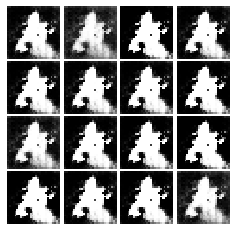

Epoch: 0, Iter: 120, D: 0.0766, G:3.592


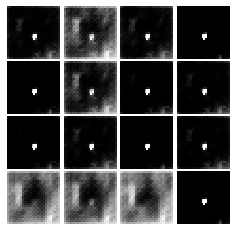

Epoch: 0, Iter: 140, D: 0.4865, G:2.485


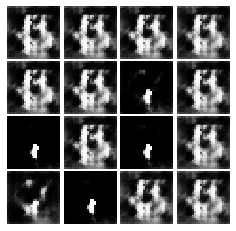

Epoch: 0, Iter: 160, D: 0.4218, G:3.273


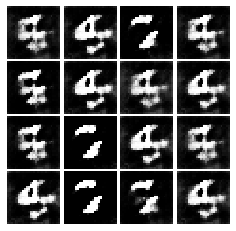

Epoch: 0, Iter: 180, D: 0.2173, G:5.767


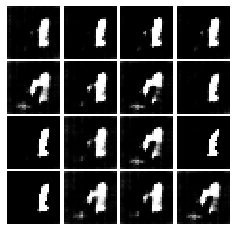

Epoch: 0, Iter: 200, D: 0.9524, G:5.712


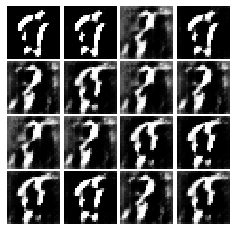

Epoch: 0, Iter: 220, D: 0.4548, G:3.29


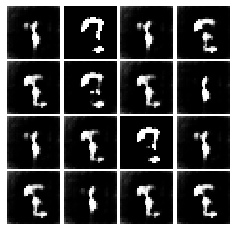

Epoch: 0, Iter: 240, D: 0.7703, G:3.315


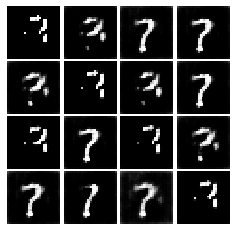

Epoch: 0, Iter: 260, D: 0.3832, G:3.567


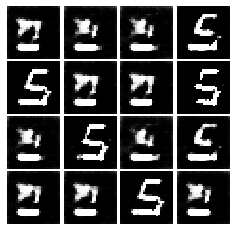

Epoch: 0, Iter: 280, D: 0.4728, G:3.037


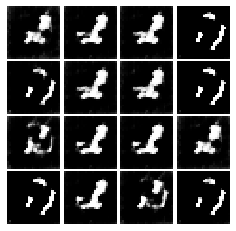

Epoch: 0, Iter: 300, D: 0.3903, G:2.759


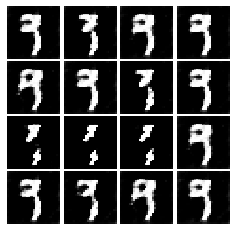

Epoch: 0, Iter: 320, D: 0.2002, G:5.097


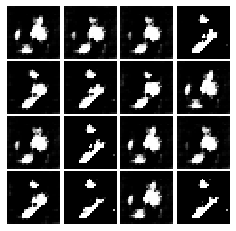

Epoch: 0, Iter: 340, D: 0.2203, G:3.548


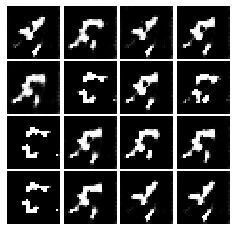

Epoch: 0, Iter: 360, D: 0.8928, G:2.077


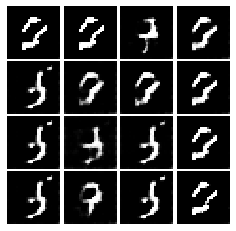

Epoch: 0, Iter: 380, D: 4.133, G:2.458


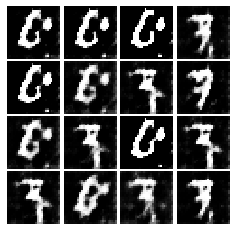

Epoch: 0, Iter: 400, D: 0.2849, G:2.612


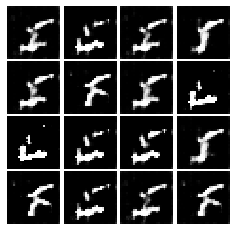

Epoch: 0, Iter: 420, D: 0.5347, G:3.242


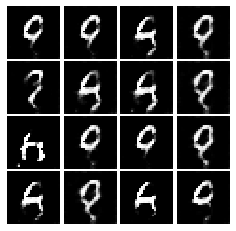

Epoch: 0, Iter: 440, D: 0.264, G:4.073


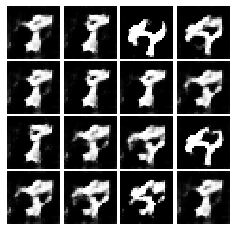

Epoch: 0, Iter: 460, D: 0.1692, G:3.39


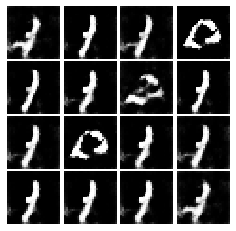

Epoch: 1, Iter: 480, D: 0.2869, G:3.538


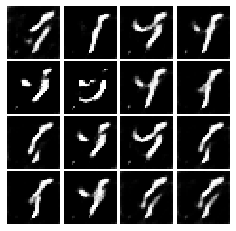

Epoch: 1, Iter: 500, D: 0.5015, G:2.094


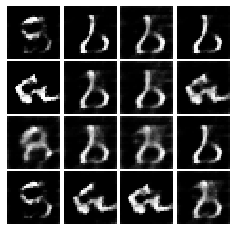

Epoch: 1, Iter: 520, D: 0.8506, G:3.082


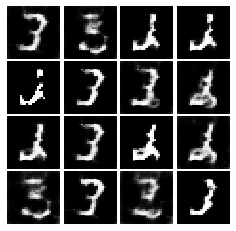

Epoch: 1, Iter: 540, D: 0.2369, G:1.626


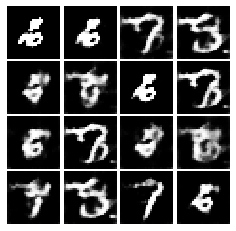

Epoch: 1, Iter: 560, D: 0.4269, G:3.495


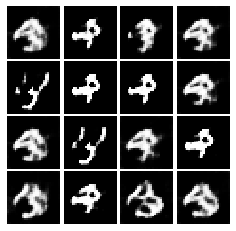

Epoch: 1, Iter: 580, D: 0.4642, G:2.123


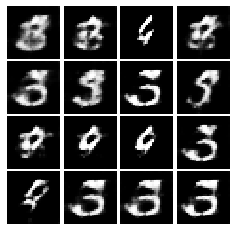

Epoch: 1, Iter: 600, D: 0.8255, G:6.869


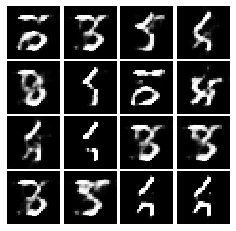

Epoch: 1, Iter: 620, D: 0.9003, G:4.401


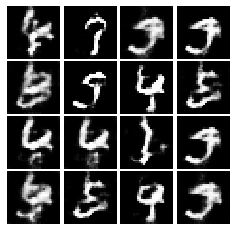

Epoch: 1, Iter: 640, D: 0.6056, G:1.478


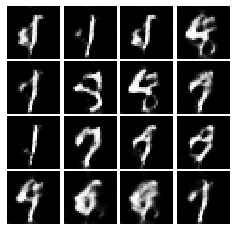

Epoch: 1, Iter: 660, D: 0.5629, G:3.195


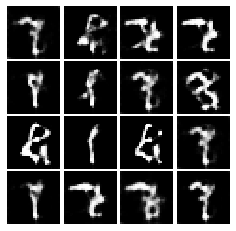

Epoch: 1, Iter: 680, D: 0.4115, G:2.9


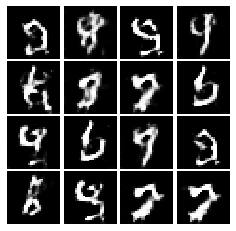

Epoch: 1, Iter: 700, D: 0.3314, G:3.304


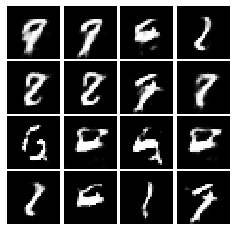

Epoch: 1, Iter: 720, D: 0.604, G:3.68


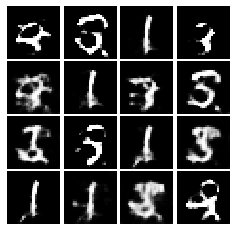

Epoch: 1, Iter: 740, D: 0.4831, G:2.262


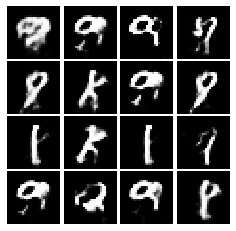

Epoch: 1, Iter: 760, D: 0.5862, G:2.342


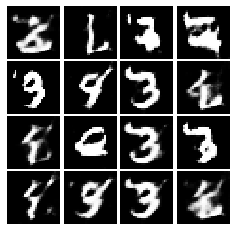

Epoch: 1, Iter: 780, D: 0.3726, G:2.858


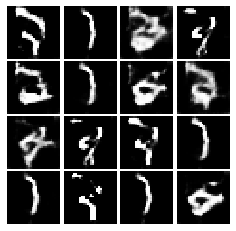

Epoch: 1, Iter: 800, D: 0.616, G:2.691


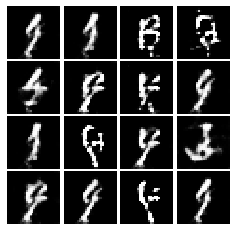

Epoch: 1, Iter: 820, D: 0.4069, G:3.416


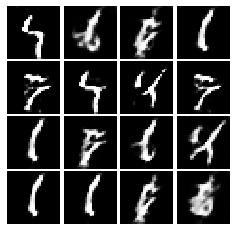

Epoch: 1, Iter: 840, D: 0.5661, G:3.807


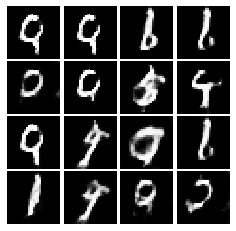

Epoch: 1, Iter: 860, D: 0.6635, G:3.027


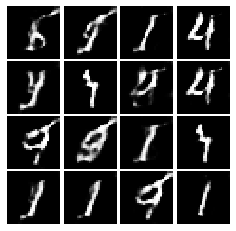

Epoch: 1, Iter: 880, D: 0.6411, G:2.339


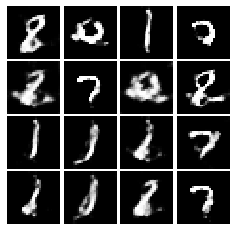

Epoch: 1, Iter: 900, D: 0.414, G:3.403


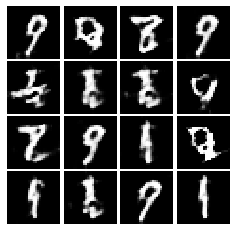

Epoch: 1, Iter: 920, D: 1.082, G:1.229


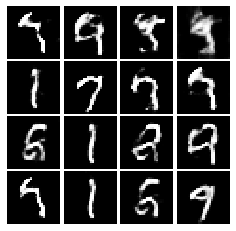

Epoch: 2, Iter: 940, D: 0.5487, G:2.258


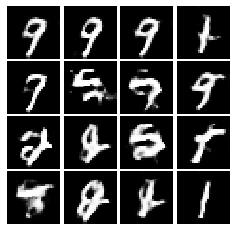

Epoch: 2, Iter: 960, D: 0.6778, G:2.275


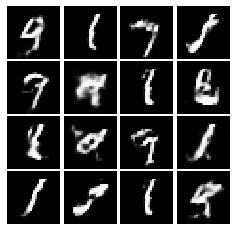

Epoch: 2, Iter: 980, D: 0.5207, G:2.143


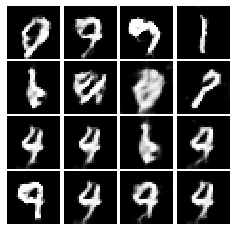

Epoch: 2, Iter: 1000, D: 0.5803, G:1.53


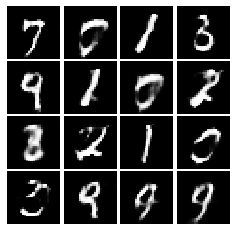

Epoch: 2, Iter: 1020, D: 0.6721, G:2.492


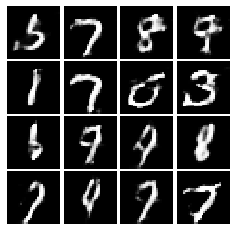

Epoch: 2, Iter: 1040, D: 1.143, G:3.906


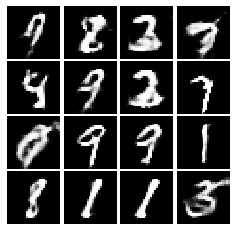

Epoch: 2, Iter: 1060, D: 0.5055, G:2.36


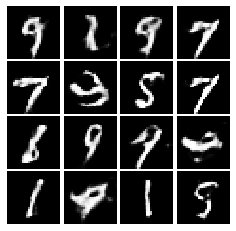

Epoch: 2, Iter: 1080, D: 0.6182, G:1.76


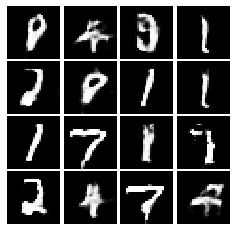

Epoch: 2, Iter: 1100, D: 0.7405, G:1.791


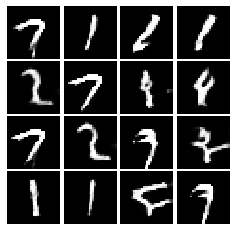

Epoch: 2, Iter: 1120, D: 0.5629, G:2.082


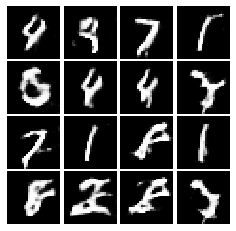

Epoch: 2, Iter: 1140, D: 0.5081, G:2.609


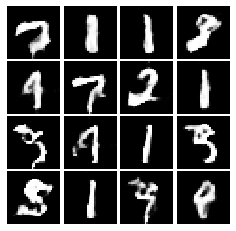

Epoch: 2, Iter: 1160, D: 0.6969, G:2.348


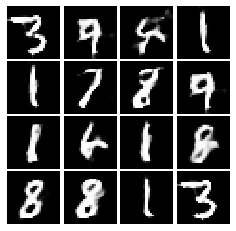

Epoch: 2, Iter: 1180, D: 0.6441, G:2.048


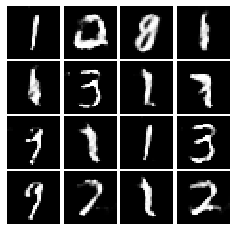

Epoch: 2, Iter: 1200, D: 0.762, G:2.101


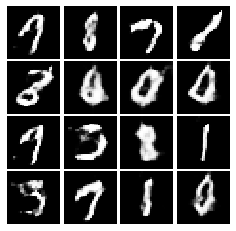

Epoch: 2, Iter: 1220, D: 0.7725, G:1.359


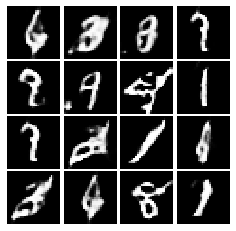

Epoch: 2, Iter: 1240, D: 0.5857, G:1.876


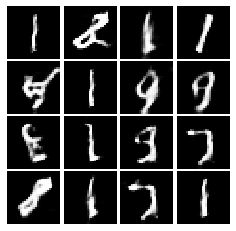

Epoch: 2, Iter: 1260, D: 0.6018, G:2.015


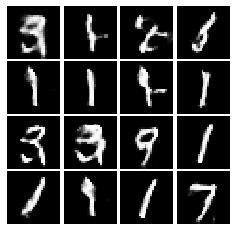

Epoch: 2, Iter: 1280, D: 0.7261, G:1.816


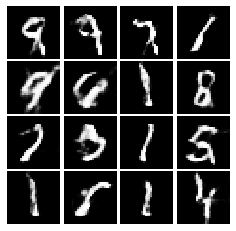

Epoch: 2, Iter: 1300, D: 0.7035, G:1.752


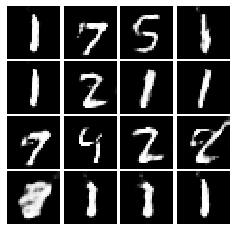

Epoch: 2, Iter: 1320, D: 0.6689, G:2.212


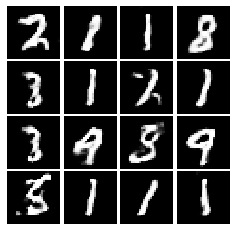

Epoch: 2, Iter: 1340, D: 0.6263, G:2.064


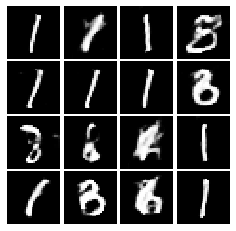

Epoch: 2, Iter: 1360, D: 0.5644, G:1.701


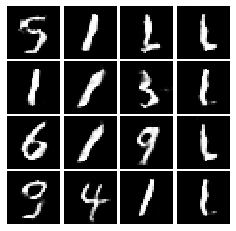

Epoch: 2, Iter: 1380, D: 0.5788, G:1.907


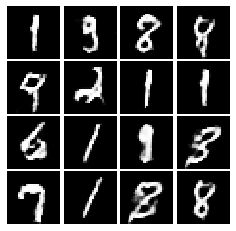

Epoch: 2, Iter: 1400, D: 0.5564, G:1.546


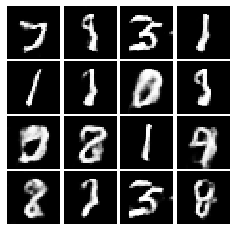

Epoch: 3, Iter: 1420, D: 0.6813, G:2.371


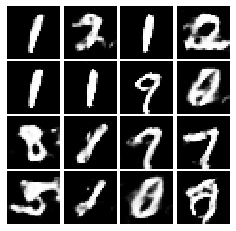

Epoch: 3, Iter: 1440, D: 0.5779, G:2.011


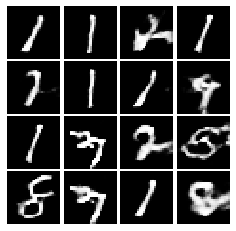

Epoch: 3, Iter: 1460, D: 0.6122, G:2.077


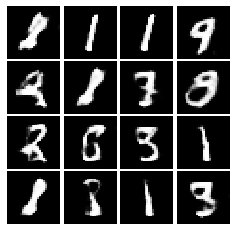

Epoch: 3, Iter: 1480, D: 0.4582, G:2.117


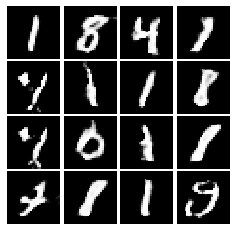

Epoch: 3, Iter: 1500, D: 0.5382, G:2.065


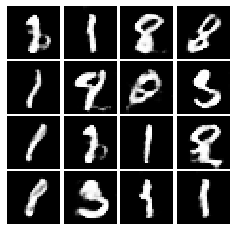

Epoch: 3, Iter: 1520, D: 0.701, G:2.356


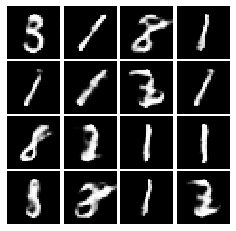

Epoch: 3, Iter: 1540, D: 0.6762, G:1.917


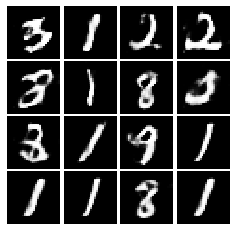

Epoch: 3, Iter: 1560, D: 0.6722, G:1.924


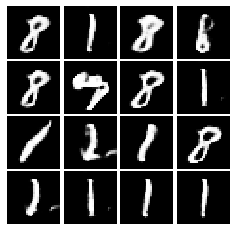

Epoch: 3, Iter: 1580, D: 0.7672, G:1.476


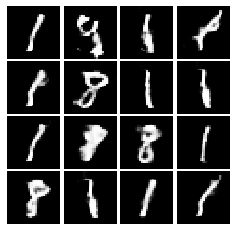

Epoch: 3, Iter: 1600, D: 0.8073, G:2.165


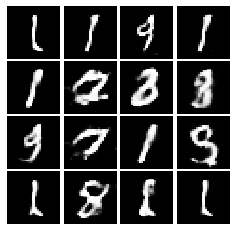

Epoch: 3, Iter: 1620, D: 0.5718, G:2.233


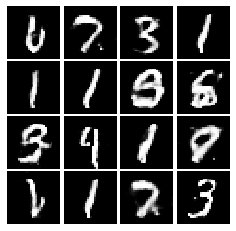

Epoch: 3, Iter: 1640, D: 0.5776, G:2.044


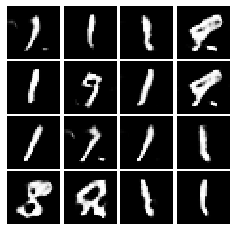

Epoch: 3, Iter: 1660, D: 0.7924, G:2.845


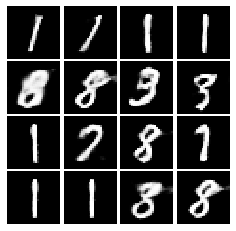

Epoch: 3, Iter: 1680, D: 0.5929, G:1.841


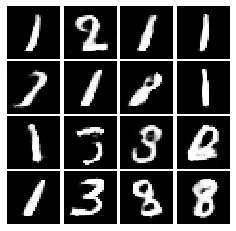

Epoch: 3, Iter: 1700, D: 0.6235, G:2.391


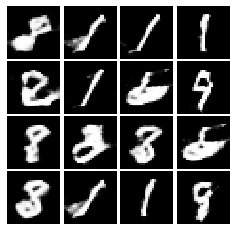

Epoch: 3, Iter: 1720, D: 0.5719, G:2.275


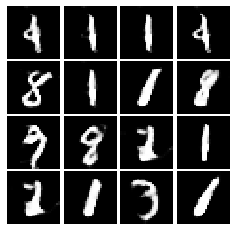

Epoch: 3, Iter: 1740, D: 0.5979, G:2.275


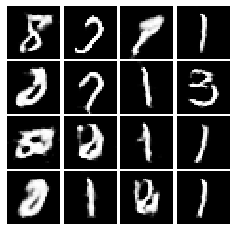

Epoch: 3, Iter: 1760, D: 0.5833, G:2.433


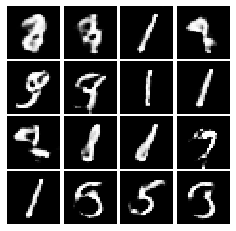

Epoch: 3, Iter: 1780, D: 0.5113, G:2.088


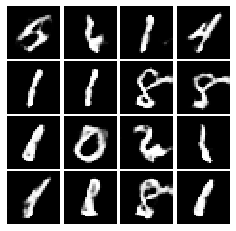

Epoch: 3, Iter: 1800, D: 0.6298, G:1.657


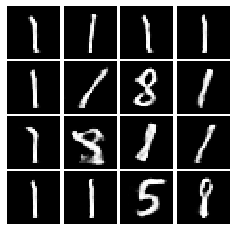

Epoch: 3, Iter: 1820, D: 0.7254, G:1.707


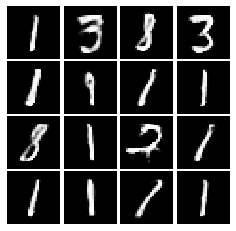

Epoch: 3, Iter: 1840, D: 0.6012, G:1.472


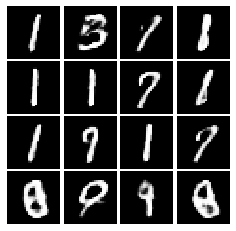

Epoch: 3, Iter: 1860, D: 0.6368, G:2.064


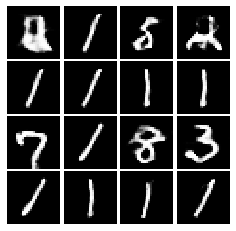

Epoch: 4, Iter: 1880, D: 0.5921, G:2.324


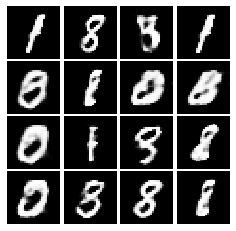

Epoch: 4, Iter: 1900, D: 0.5337, G:1.946


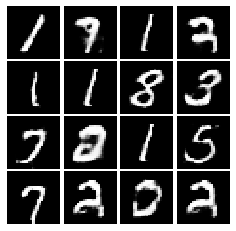

Epoch: 4, Iter: 1920, D: 0.6026, G:2.361


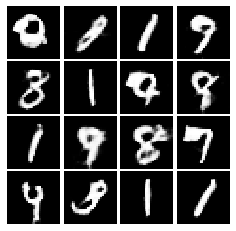

Epoch: 4, Iter: 1940, D: 0.5336, G:2.625


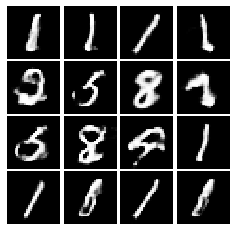

Epoch: 4, Iter: 1960, D: 0.5173, G:1.811


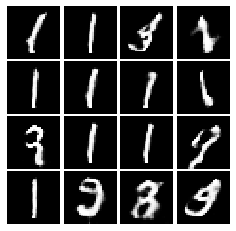

Epoch: 4, Iter: 1980, D: 0.5047, G:2.23


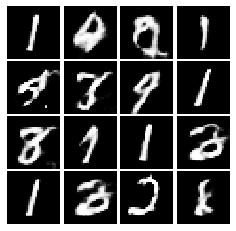

Epoch: 4, Iter: 2000, D: 0.6927, G:2.019


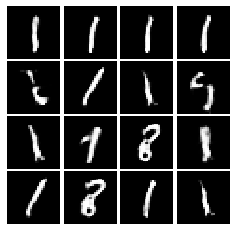

Epoch: 4, Iter: 2020, D: 0.5713, G:2.507


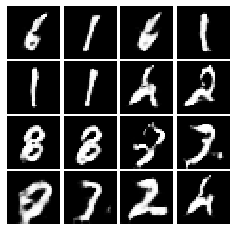

Epoch: 4, Iter: 2040, D: 0.5738, G:1.822


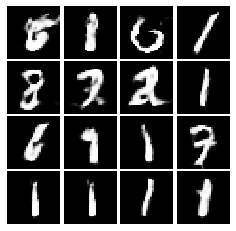

Epoch: 4, Iter: 2060, D: 0.3746, G:2.203


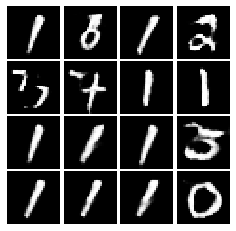

Epoch: 4, Iter: 2080, D: 0.6543, G:2.046


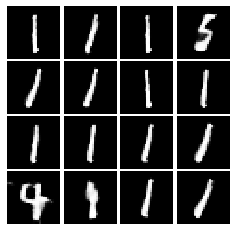

Epoch: 4, Iter: 2100, D: 0.5141, G:2.282


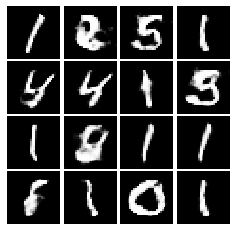

Epoch: 4, Iter: 2120, D: 0.7374, G:1.281


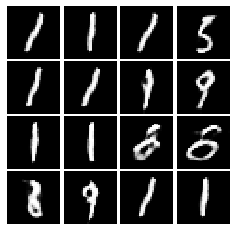

Epoch: 4, Iter: 2140, D: 0.6668, G:2.271


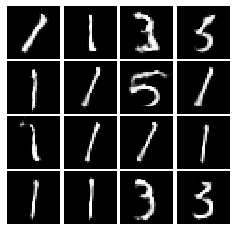

Epoch: 4, Iter: 2160, D: 0.5712, G:2.332


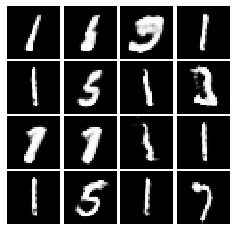

Epoch: 4, Iter: 2180, D: 0.5201, G:2.53


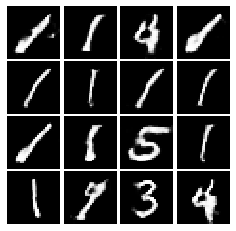

Epoch: 4, Iter: 2200, D: 0.6973, G:2.206


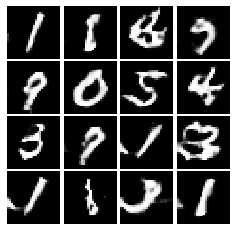

Epoch: 4, Iter: 2220, D: 0.4846, G:2.03


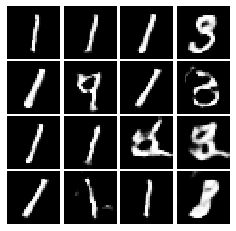

Epoch: 4, Iter: 2240, D: 0.5336, G:2.023


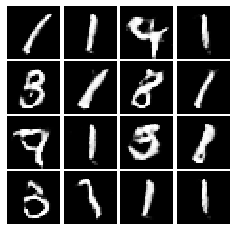

Epoch: 4, Iter: 2260, D: 0.5147, G:1.91


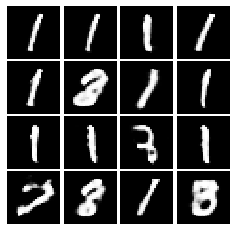

Epoch: 4, Iter: 2280, D: 0.6008, G:2.756


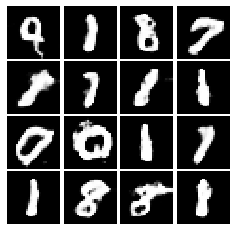

Epoch: 4, Iter: 2300, D: 0.5325, G:1.899


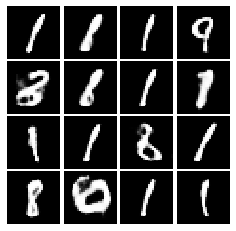

Epoch: 4, Iter: 2320, D: 0.5435, G:2.437


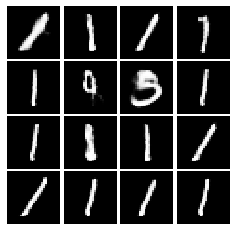

Epoch: 4, Iter: 2340, D: 0.6052, G:1.928


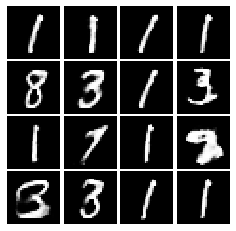

Final images


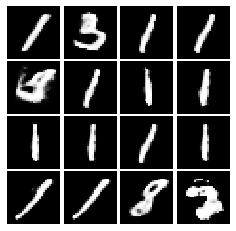

In [107]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, num_epochs=5)

## INLINE QUESTION 1

We will look at an example to see why alternating minimization of the same objective (like in a GAN) can be tricky business.

Consider $f(x,y)=xy$. What does $\min_x\max_y f(x,y)$ evaluate to? (Hint: minmax tries to minimize the maximum value achievable.)

Now try to evaluate this function numerically for 6 steps, starting at the point $(1,1)$, 
by using alternating gradient (first updating y, then updating x using that updated y) with step size $1$. **Here step size is the learning_rate, and steps will be learning_rate * gradient.**
You'll find that writing out the update step in terms of $x_t,y_t,x_{t+1},y_{t+1}$ will be useful.

Breifly explain what $\min_x\max_y f(x,y)$ evaluates to and record the six pairs of explicit values for $(x_t,y_t)$ in the table below.

### Your answer:
 
 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$ 
 ----- | ----- | ----- | ----- | ----- | ----- | ----- 
   1   |       |       |       |       |       |       
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$ 
   1   |       |       |       |       |       |       
   


## INLINE QUESTION 2
Using this method, will we ever reach the optimal value? Why or why not?

### Your answer: 


## INLINE QUESTION 3
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient.

### Your answer: 
